# 0. Chargement des données

In [1]:
########### Preparation ##############
# import packages
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.lines import Line2D

In [2]:
ELfriendG = nx.read_edgelist('ELfriend_edgelist.txt',comments="node",create_using=nx.DiGraph(),nodetype=int)
ELcoworkG = nx.read_edgelist('ELcowork_edgelist.txt',comments="node",create_using=nx.Graph(),nodetype=int)
ELcoworkG = nx.DiGraph.to_directed(ELcoworkG)
ELadviceG = nx.read_edgelist('ELadvice_edgelist.txt',comments="node",create_using=nx.DiGraph(),nodetype=int)
ELnodes = pd.read_csv("ELnodeAttributes.txt", sep='\t')
ELNodeData = ELnodes.set_index('Node').to_dict('index').items()
ELfriendG.name = "ELfriend"
ELcoworkG.name = "ELcowork"
ELadviceG.name = "Eladvice"
ELfriendG.add_nodes_from(ELNodeData)
ELcoworkG.add_nodes_from(ELNodeData)
ELadviceG.add_nodes_from(ELNodeData)
print(nx.info(ELadviceG), '\n\n', nx.info(ELfriendG), '\n\n', nx.info(ELcoworkG),sep="")

Name: Eladvice
Type: DiGraph
Number of nodes: 71
Number of edges: 892
Average in degree:  12.5634
Average out degree:  12.5634

Name: ELfriend
Type: DiGraph
Number of nodes: 71
Number of edges: 575
Average in degree:   8.0986
Average out degree:   8.0986

Name: ELcowork
Type: DiGraph
Number of nodes: 71
Number of edges: 756
Average in degree:  10.6479
Average out degree:  10.6479


On crée un `MultiDiGraph` avec les trois bases ElAdvice, Elfriend et Elcowork.

In [3]:
for e1, e2 in list(ELadviceG.edges):
    ELadviceG.edges[e1,e2]["type"]="Advice"
for e1, e2 in list(ELfriendG.edges):
    ELfriendG.edges[e1,e2]["type"]="Friend"
for e1, e2 in list(ELcoworkG.edges):
    ELcoworkG.edges[e1,e2]["type"]="Cowork"
LawyersMG = nx.MultiDiGraph(ELadviceG)
LawyersMG.add_edges_from(list(ELfriendG.edges(data=True)))
LawyersMG.add_edges_from(list(ELcoworkG.edges(data=True)))
print(nx.info(LawyersMG))

Name: Eladvice
Type: MultiDiGraph
Number of nodes: 71
Number of edges: 2223
Average in degree:  31.3099
Average out degree:  31.3099


Pour les *ego-centered* graphe, j'ai choisi de m'intéresser à l'individu 64 qui est celui qui maximisait la betweeness-centrality sur la base ELfriend.

In [4]:
id_lawyer = 64
egoi_advice = nx.ego_graph(ELadviceG, id_lawyer, undirected=True)
print("L'individu choisi est le",id_lawyer,
      "\nSes attributs sont :\n ", ELfriendG.nodes(data=True)[id_lawyer],
     "\nLes sommets qui constituent l'ego-centered graph sur cet individu sur la base ELadvice sont:\n ",
     egoi_advice.nodes())

L'individu choisi est le 64 
Ses attributs sont :
  {'Status': 2, 'Gender': 2, 'Office': 1, 'Senior': 2, 'Age': 45, 'Spec': 2, 'School': 2} 
Les sommets qui constituent l'ego-centered graph sur cet individu sur la base ELadvice sont:
  [64, 65, 2, 34, 66, 69, 7, 10, 13, 48, 16, 19, 53, 22, 24, 56, 61, 62]


# 1. Analyse sur la base ELadvice

In [5]:
egoi_advice_noEgo = egoi_advice.copy()
egoi_advice_noEgo.remove_node(id_lawyer)

Dans l'*ego-centered* graphe autour de l'individu 64 il y a 18 noeuds, 87 arêtes et un nombre moyen de in/out degree de 4,9 :

In [6]:
print(nx.info(egoi_advice))

Name: Eladvice
Type: DiGraph
Number of nodes: 18
Number of edges: 87
Average in degree:   4.8333
Average out degree:   4.8333


In [ ]:
node_col = []
for node in egoi_advice:
    if node == id_lawyer:
        node_col.append('orange')
    else:
        node_col.append('lightblue')
nx.draw_kamada_kawai(egoi_advice, node_color=node_col, with_labels=True)
plt.title("Ego-centred graph on lawyer {}".format(id_lawyer))
plt.show()
nx.draw_kamada_kawai(egoi_advice_noEgo, with_labels=True, node_color="lightblue")
plt.title("Ego-centred graph on lawyer {} without ego node".format(id_lawyer))
plt.show()

In [8]:
def composite_indicators(G, col):
    data = list(G.nodes(data=col))
    data = [y for x,y in data]
    if(data[0] is None):
        return {"blau": None, "iqv": None, "hhi": None, "k": None, "col": col}
    else:
        data = pd.DataFrame(data)[0]
        # Blau = B = 1 - p1^2 - p2^2 - ... - pk^2
        blau = (1- ((data.value_counts() / data.count()) ** 2).sum())
        k = len(ELnodes[col].unique()) # on prend la valeur globale et pas celle de la sous-base
        # IQV = blau * k / (k-1), indicateur renormalisé
        iqv = blau*k/(k-1)
        # HHI
        hhi = 1 - blau
        return {"B": blau, "IQV":iqv, "HHI": hhi,
                "k_global":k, # nombre de modalités dans la base entière
                "k_local":len(data.unique()), # nomùbre de modalités dans le sous-graph
                "col": col}

En calculant différents indicateurs de composition, on peut noter que pour les *alter* de l'individu 64 :
- il y a quasiment d'avocats "partners" que de "associate" (parfaite parité si l'on inclut l'ego) ;
- les catégories de genre, d'école et d'exercice ("spec") sont relativement bien répartis entre les différentes modalités ;
- en revanche, la modalité du lieu de travail ("Work") est mal répartie : 16 individus travaillent à Boston (comme l'individu 64), 1 individu à Hartford et 0 à Providence. Cette mauvaise répartition spatiale parait logique: on demande plus facilement conseil à des personnes qui sont géographiquement proches de soi et l'individu 64 travaille à a parait logique que pour demander un conseil.

In [10]:
print(composite_indicators(egoi_advice_noEgo, "Status"))
print(composite_indicators(egoi_advice_noEgo, "Gender"))
print(composite_indicators(egoi_advice_noEgo, "Office"))
print(composite_indicators(egoi_advice_noEgo, "Spec"))
print(composite_indicators(egoi_advice_noEgo, "School"))
# Visualisaiton distribution variable Office:
data = list(egoi_advice_noEgo.nodes(data="Office"))
data = [y for x,y in data]
data = pd.DataFrame(data)[0]
print("\nRepartition de la variable office dans egoi_advice:\n",
      data.value_counts(),
      "\nRepartition de la variable office dans la base complète:\n",
      ELnodes["Office"].value_counts(),
      sep="")

{'B': 0.4982698961937716, 'IQV': 0.9965397923875432, 'HHI': 0.5017301038062284, 'k_global': 2, 'k_local': 2, 'col': 'Status'}
{'B': 0.3598615916955018, 'IQV': 0.7197231833910036, 'HHI': 0.6401384083044982, 'k_global': 2, 'k_local': 2, 'col': 'Gender'}
{'B': 0.11072664359861584, 'IQV': 0.16608996539792376, 'HHI': 0.8892733564013842, 'k_global': 3, 'k_local': 2, 'col': 'Office'}
{'B': 0.4844290657439446, 'IQV': 0.9688581314878892, 'HHI': 0.5155709342560554, 'k_global': 2, 'k_local': 2, 'col': 'Spec'}
{'B': 0.6020761245674741, 'IQV': 0.9031141868512111, 'HHI': 0.39792387543252594, 'k_global': 3, 'k_local': 3, 'col': 'School'}

Repartition de la variable office dans egoi_advice:
1    16
2     1
Name: 0, dtype: int64
Repartition de la variable office dans la base complète:
1    48
2    19
3     4
Name: Office, dtype: int64


Il y a plus de liens avec des personnes qui sont jeunes dans le cabinet d'avocat (comme l'individu 64) mais une relative bonne répartition des autres années d'ancienneté. La tranche d'age est relativement bien répartie.

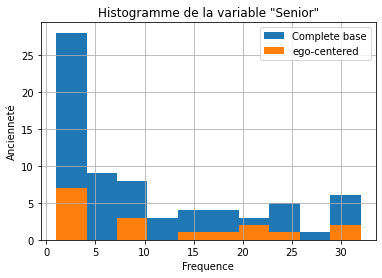

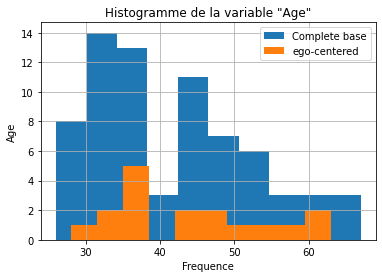

In [11]:
ELnodes["Senior"].hist(label='Complete base')
ELnodes[ELnodes.Node.isin(list(egoi_advice_noEgo.nodes()))]["Senior"].hist(label='ego-centered')
plt.ylabel('Ancienneté')
plt.xlabel('Frequence')
plt.title('Histogramme de la variable "{}"'.format("Senior")
         )
plt.legend()

plt.show()
ELnodes["Age"].hist(label='Complete base')
ELnodes[ELnodes.Node.isin(list(egoi_advice_noEgo.nodes()))]["Age"].hist(label='ego-centered')
plt.ylabel('Age')
plt.xlabel('Frequence')
plt.title('Histogramme de la variable "{}"'.format("Age")
         )
plt.legend()

On pouvait directement le voir graphiquement mais le sous-graph n'est pas fortement connecté mais faiblement connecté par construction (idem si on enlève le noeud 64 car il n'y a pas de noeud isolé).

In [12]:
print("Est-ce que le graphe est fortement connecté ?",
      nx.is_strongly_connected(egoi_advice))
print("Est-ce que le graphe est faiblement connecté ?",
      nx.is_weakly_connected(egoi_advice))

Est-ce que le graphe est fortement connecté ? False
Est-ce que le graphe est faiblement connecté ? True


Les graphes sont assez denses, cela se retrouve sur l'APE qui est assez faible. Cependant, la *reciprocity* est assez faible (environ 65 % de liens non réciproques).

In [13]:
egoi_advice_noEgoUG = nx.DiGraph.to_undirected(egoi_advice_noEgo)
egoi_adviceUG = nx.DiGraph.to_undirected(egoi_advice)
print("Diamètre graph = {}, diamètre without ego = {}".format(nx.diameter(egoi_adviceUG),
                                                             nx.diameter(egoi_advice_noEgoUG)))
print("Density Digraph = {}, Density undirected graph = {}".format(round(nx.density(egoi_advice),2),
                                                             round(nx.density(egoi_adviceUG),2)))
print("Without ego, Density Digraph = {}, Density undirected graph = {}".format(round(nx.density(egoi_advice_noEgo),2),
                                                             round(nx.density(egoi_advice_noEgoUG),2)))
## average shortest path length
print("A.P.E. = {}, without ego = {}".format(round(nx.average_shortest_path_length(egoi_advice),2),
                                            round(nx.average_shortest_path_length(egoi_advice_noEgo),2)))
print("Reciprocity = {}, without ego = {}".format(round(nx.reciprocity(egoi_advice),2),
                                            round(nx.reciprocity(egoi_advice_noEgo),2)))
    

Diamètre graph = 2, diamètre without ego = 4
Density Digraph = 0.28, Density undirected graph = 0.48
Without ego, Density Digraph = 0.25, Density undirected graph = 0.41
A.P.E. = 1.22, without ego = 1.32
Reciprocity = 0.32, without ego = 0.38


Si l'on regarde les autres indicateurs, on peut noter que presque la moitié des triades sont transitives, dans le sous-graphe sans l'ego, l'individu qui maximise la *out-degree centrality* est un individu qui a peu d'ancienneté (ce qui parait logique puisqu'il a plus tendance à demander des conseils qu'à en donner) et les individus qui maximisent la *in-degree centrality* et la *betweeness centrality* ont beaucoup d'ancienneté.

In [14]:
# Fonction pour trier par ordre croissant un dictionnaire
# @param nb_dec paramètre pour arrondir les valeurs pour augmenter lisibilité de la sortie
def trie_dict(dico,nb_dec=2):
    res = {i:round(dico[i],nb_dec) for i in sorted(dico.keys())}
    res = dict([(x,round(y,2)) for x,y in sorted(dico.items(), key=lambda item: item[1], reverse = True)])
    return(res)
##### Transitivity
print(("Global clustering coefficient = {}"+
      ", without ego = {}").format(round(nx.transitivity(egoi_advice),2),
                                  round(nx.transitivity(egoi_advice_noEgo),2)))

# Clustering
print(("Local clustering coefficient = \n{}"+
      "\n, without ego = \n{}").format(trie_dict(nx.clustering(egoi_advice),nb_dec=2),
                                  trie_dict(nx.clustering(egoi_advice_noEgo),nb_dec=2)))
## take the average:
print(("Average clustering coefficient = {}"+
      ", without ego = {}").format(round(nx.average_clustering(egoi_advice),2),
                                  round(nx.average_clustering(egoi_advice_noEgo),2)))

################# Centrality
in_d_cen_egoadvice = trie_dict(nx.in_degree_centrality(egoi_advice),nb_dec = 2)
out_d_cen_egoadvice= trie_dict(nx.out_degree_centrality(egoi_advice),nb_dec = 2)
ind_max_in_d_cen = list(in_d_cen_egoadvice.keys())[1]
ind_max_out_d_cen = list(out_d_cen_egoadvice.keys())[1]

print("\nin_degree_centrality pour ego-graph")
print(in_d_cen_egoadvice)
print("L'individu qui maximise le in-degree de centralité (après 64) est le",ind_max_in_d_cen,
      "\nSes attributs sont :", egoi_advice.nodes(data=True)[ind_max_in_d_cen],"\n")
print("out_degree_centrality pour ego-graph")
print(out_d_cen_egoadvice)
print("L'individu qui maximise le out-degree de centralité (après 64) est le",ind_max_out_d_cen,
      "\nSes attributs sont :", egoi_advice.nodes(data=True)[ind_max_out_d_cen])

# Betweenness centrality
b_c_egoi_advice= trie_dict(nx.betweenness_centrality(egoi_advice),nb_dec = 2)
ind_max_b_c_advice = list(b_c_egoi_advice.keys())[1]

print("\nBetweeness centrality pour ego-graph :",
      b_c_egoi_advice, sep="\n")
print("L'individu qui maximise la betweeness centrality (après 64) est le",ind_max_b_c_advice,
      "\nSes attributs sont :", egoi_advice.nodes(data=True)[ind_max_b_c_advice],"\n")

Global clustering coefficient = 0.45, without ego = 0.44
Local clustering coefficient = 
{7: 0.65, 48: 0.59, 62: 0.57, 53: 0.56, 69: 0.56, 10: 0.5, 61: 0.5, 19: 0.46, 56: 0.4, 2: 0.4, 16: 0.39, 13: 0.38, 65: 0.37, 66: 0.36, 34: 0.34, 22: 0.33, 24: 0.32, 64: 0.25}
, without ego = 
{7: 0.75, 48: 0.62, 62: 0.61, 53: 0.61, 69: 0.6, 10: 0.49, 19: 0.43, 56: 0.37, 2: 0.37, 16: 0.36, 13: 0.34, 65: 0.34, 66: 0.31, 34: 0.3, 24: 0.28, 22: 0.28, 61: 0}
Average clustering coefficient = 0.44, without ego = 0.42

in_degree_centrality pour ego-graph
{64: 0.59, 2: 0.59, 34: 0.59, 24: 0.53, 10: 0.41, 13: 0.41, 16: 0.41, 22: 0.35, 65: 0.24, 53: 0.24, 56: 0.18, 62: 0.18, 7: 0.12, 19: 0.12, 66: 0.06, 69: 0.06, 48: 0.06, 61: 0.0}
L'individu qui maximise le in-degree de centralité (après 64) est le 2 
Ses attributs sont : {'Status': 1, 'Gender': 1, 'Office': 1, 'Senior': 32, 'Age': 62, 'Spec': 2, 'School': 1} 

out_degree_centrality pour ego-graph
{64: 0.47, 66: 0.47, 16: 0.47, 48: 0.41, 19: 0.41, 65: 0.35, 

# 2. Graphe complet

Il y a un presque la moitié des noeuds dans l'ego-graph de 64 (pour rappel cet avocat maximisait la betweeness centrality de Elfriend, on pouvait donc s'attendre à ce qu'il y ait beaucoup de noeuds)

In [16]:
ego_comp = nx.ego_graph(LawyersMG, id_lawyer, undirected=True)
ego_comp_noEgo = ego_comp.copy()
ego_comp_noEgo.remove_node(id_lawyer)
print(nx.info(ego_comp))

Name: Eladvice
Type: MultiDiGraph
Number of nodes: 31
Number of edges: 516
Average in degree:  16.6452
Average out degree:  16.6452


In [17]:
graph_dic ={"Advice": ("->","gray",1*0.3),
            "Friend": ("<->","green",2*0.3),
            "Cowork": ("->", "orange",3*0.3)}
legend_elements = [Line2D([0], [0], marker='>', color='gray', label='ELadvice',
                          markersize=8),
                   Line2D([0], [0], marker='>', color='green', label='ELfriend',
                          markersize=8),
                   Line2D([0], [0], marker='>', color='orange', label='ELcowork',
                          markersize=8),
                   Line2D([0], [0], marker='o', color='lightblue', label='Man',
                          markerfacecolor='lightblue', markersize=15),
                   Line2D([0], [0], marker='o', color='pink', label='Women',
                          markerfacecolor='pink', markersize=15)
                  ]
def plot_mg(data, title = ""):
    color = 'Gender'
    node_col = []
    for node in data.nodes(data=True):
        if node[1][color]==1:
            node_col.append('lightblue')
        else:
            node_col.append('pink')
    plt.figure(figsize=(12, 8))
    pos = nx.kamada_kawai_layout(data)
    ax = plt.gca()
    for e in data.edges(data=True):
        arrowstyle, color, rad = graph_dic[e[2]["type"]]
        ax.annotate("",
                    xy=pos[e[0]], xycoords='data',
                    xytext=pos[e[1]], textcoords='data',
                    arrowprops=dict(arrowstyle=arrowstyle,shrinkA=10, shrinkB=10,
                                    color=color,
                                    #shrink=0.1,width = 0.5,headwidth = 5,
                                    patchA=None, patchB=None,
                                    connectionstyle="arc3,rad={}".format(0),
                                    alpha=.7
                                    ),
                    )
    nx.draw_networkx_nodes(data, pos, node_color = node_col, node_size = 300, alpha = 1)
    nx.draw_networkx_labels(data, pos)
    plt.legend(handles=legend_elements, loc='upper left')
    plt.title(title)
    plt.axis('off')

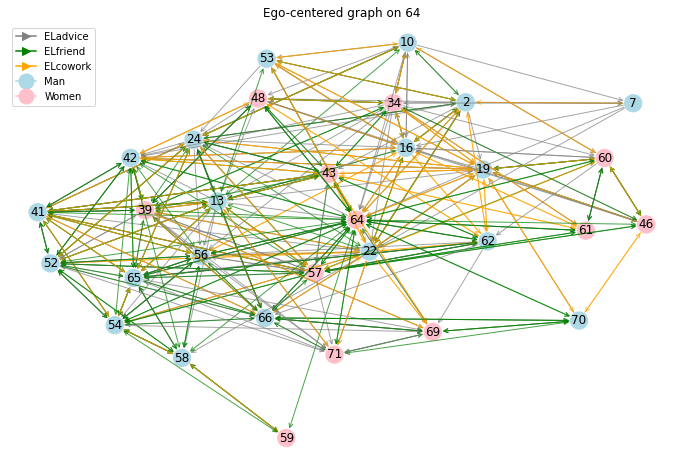

In [18]:
plot_mg(ego_comp, title = "Ego-centered graph on 64")

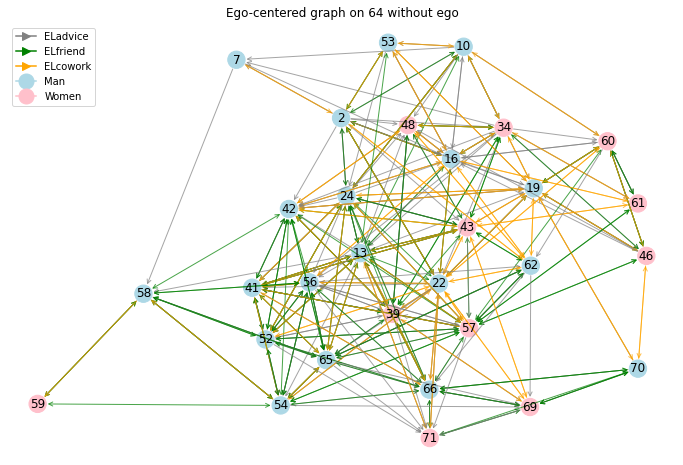

In [19]:
plot_mg(ego_comp_noEgo, title = "Ego-centered graph on 64 without ego")

On crée également un weighted-graph pour mesurer la force des liens et simplifier les liens redondants dans le graphique précédent. On le fait sur le sous-graphe sans ego.

Name: 
Type: DiGraph
Number of nodes: 30
Number of edges: 286
Average in degree:   9.5333
Average out degree:   9.5333


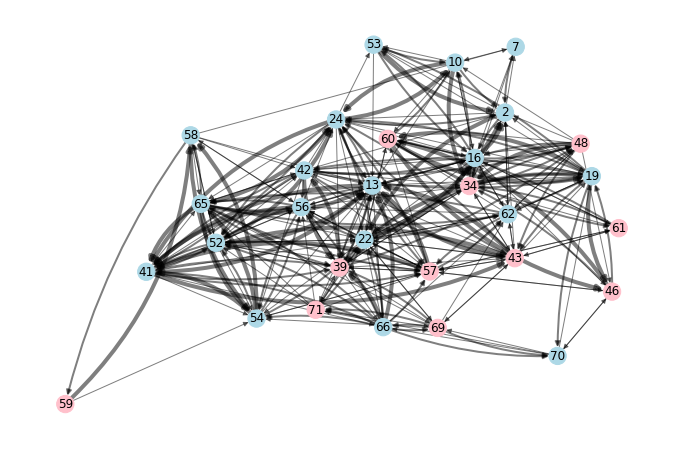

In [20]:
ego_compWUG = nx.DiGraph()
for u,v,data in ego_comp_noEgo.edges(data=True):
    w = 1   
    if ego_compWUG.has_edge(u,v):
        ego_compWUG[u][v]['weight'] += w
    else:
        ego_compWUG.add_edge(u, v, weight=w)
ego_compWUG.add_nodes_from(ego_comp_noEgo.nodes(data=True))
print(nx.info(ego_compWUG))

weakTies = [(u, v) for (u, v, d) in ego_compWUG.edges(data=True) if d["weight"] == 1]
mediumTies = [(u, v) for (u, v, d) in ego_compWUG.edges(data=True) if d["weight"] == 2]
strongTies = [(u, v) for (u, v, d) in ego_compWUG.edges(data=True) if d["weight"] == 3]

color = 'Gender'
node_col = []
for node in ego_compWUG.nodes(data=True):
    if node[1][color]==1:
        node_col.append('lightblue')
    else:
        node_col.append('pink')
plt.figure(figsize=(12, 8))
pos = nx.kamada_kawai_layout(ego_compWUG)
# nodes
nx.draw_networkx_nodes(ego_compWUG, pos, node_color = node_col,
                       node_size = 300, alpha = 1)
nx.draw_networkx_labels(ego_compWUG, pos)
nx.draw_networkx_edges(ego_compWUG, pos, edgelist=weakTies, width=1,alpha=0.5,connectionstyle="arc3,rad=0.") # weak ties
nx.draw_networkx_edges(ego_compWUG, pos, edgelist=mediumTies, width=2,alpha=0.5,connectionstyle="arc3,rad=0.1")  # medium ties
nx.draw_networkx_edges(ego_compWUG, pos, edgelist=strongTies, width=4,alpha=0.5,connectionstyle="arc3,rad=0.2")  # strong ties
plt.axis('off')
plt.show()

Comme précédemment, les différentes catégories sont relativement bien réparties pour les *alter* de l'individu 64, sauf pour la variable "Office" qui est mal répartie dans le graphe entier.

In [21]:
print(composite_indicators(ego_comp_noEgo, "Status"))
print(composite_indicators(ego_comp_noEgo, "Gender"))
print(composite_indicators(ego_comp_noEgo, "Office"))
print(composite_indicators(ego_comp_noEgo, "Spec"))
print(composite_indicators(ego_comp_noEgo, "School"))
# Visualisaiton distribution variable Office:
data = list(ego_comp_noEgo.nodes(data="Office"))
data = [y for x,y in data]
data = pd.DataFrame(data)[0]
print("\nRepartition de la variable office dans ego_comp:\n",
      data.value_counts(),
      "\nRepartition de la variable office dans la base complète:\n",
      ELnodes["Office"].value_counts(),
      sep="")

{'B': 0.42000000000000004, 'IQV': 0.8400000000000001, 'HHI': 0.58, 'k_global': 2, 'k_local': 2, 'col': 'Status'}
{'B': 0.46444444444444444, 'IQV': 0.9288888888888889, 'HHI': 0.5355555555555556, 'k_global': 2, 'k_local': 2, 'col': 'Gender'}
{'B': 0.23111111111111104, 'IQV': 0.34666666666666657, 'HHI': 0.768888888888889, 'k_global': 3, 'k_local': 2, 'col': 'Office'}
{'B': 0.49777777777777776, 'IQV': 0.9955555555555555, 'HHI': 0.5022222222222222, 'k_global': 2, 'k_local': 2, 'col': 'Spec'}
{'B': 0.6044444444444443, 'IQV': 0.9066666666666665, 'HHI': 0.39555555555555566, 'k_global': 3, 'k_local': 3, 'col': 'School'}

Repartition de la variable office dans ego_comp:
1    26
2     4
Name: 0, dtype: int64
Repartition de la variable office dans la base complète:
1    48
2    19
3     4
Name: Office, dtype: int64


La distribution de l'ancienneté ("Senior") et de l'age dans l'*ego-centered graph* suit la même que la base globale : bien plus d'individus ayant peu d'ancienneté mais une bonne répartition pour les autres années, plus de personnes de moins de 40 ans que l'inverse.

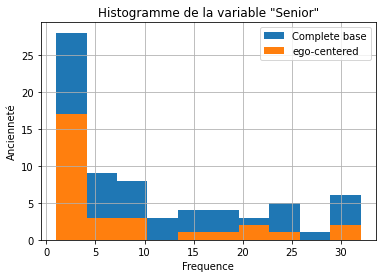

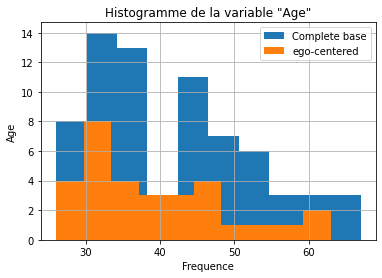

In [22]:
ELnodes["Senior"].hist(label='Complete base')
ELnodes[ELnodes.Node.isin(list(ego_comp_noEgo.nodes()))]["Senior"].hist(label='ego-centered')
plt.ylabel('Ancienneté')
plt.xlabel('Frequence')
plt.title('Histogramme de la variable "{}"'.format("Senior")
         )
plt.legend()

plt.show()
ELnodes["Age"].hist(label='Complete base')
ELnodes[ELnodes.Node.isin(list(ego_comp.nodes()))]["Age"].hist(label='ego-centered')
plt.ylabel('Age')
plt.xlabel('Frequence')
plt.title('Histogramme de la variable "{}"'.format("Age")
         )
plt.legend()

Du fait des nombreux types d'arêtes, le graphe est maintenant fortement connecté !

In [177]:
print("Est-ce que le graphe est fortement connecté ?",
      nx.is_strongly_connected(ego_comp))

Est-ce que le graphe est fortement connecté ? True


Les graphes sont assez denses, cela se retrouve sur l'APE qui est assez faible, la *reciprocity* est assez élevée (environ 30 % de liens non réciproques).

In [23]:
ego_comp_noEgoUG = nx.DiGraph.to_undirected(ego_comp_noEgo)
ego_compUG = nx.DiGraph.to_undirected(ego_comp)
print("Diamètre graph = {}, diamètre without ego = {}".format(nx.diameter(ego_compUG),
                                                             nx.diameter(ego_comp_noEgoUG)))
print("Density Digraph = {}, Density undirected graph = {}".format(round(nx.density(ego_comp),2),
                                                             round(nx.density(ego_compUG),2)))
print("Without ego, Density Digraph = {}, Density undirected graph = {}".format(round(nx.density(ego_comp_noEgo),2),
                                                             round(nx.density(ego_comp_noEgoUG),2)))
## average shortest path length
print("A.P.E. = {}, without ego = {}".format(round(nx.average_shortest_path_length(ego_comp),2),
                                            round(nx.average_shortest_path_length(ego_comp_noEgo),2)))
print("Reciprocity = {}, without ego = {}".format(round(nx.reciprocity(ego_comp),2),
                                            round(nx.reciprocity(ego_comp_noEgo),2)))
    

Diamètre graph = 2, diamètre without ego = 3
Density Digraph = 0.55, Density undirected graph = 0.45
Without ego, Density Digraph = 0.52, Density undirected graph = 0.41
A.P.E. = 1.7, without ego = 1.82
Reciprocity = 0.68, without ego = 0.69


Ci-dessous les statistiques relatives aux autres indicateurs.

In [24]:
##### Transitivity
print("Global clustering coefficient (weighted graph without ego) = {}".format(round(nx.transitivity(ego_compWUG),2)))

# Clustering
print("Local clustering coefficient (weighted graph without ego):\n",
      trie_dict(nx.clustering(ego_compWUG),nb_dec=2), sep="")  # measure is by node (local clustering coefficient)
## take the average:
print("Average clustering coefficient (weighted graph without ego) = {}".format(round(nx.average_clustering(ego_compWUG),2)))

################# Centrality
in_d_cen_egoadvice = trie_dict(nx.in_degree_centrality(ego_comp),nb_dec = 2)
out_d_cen_egoadvice= trie_dict(nx.out_degree_centrality(ego_comp),nb_dec = 2)
ind_max_in_d_cen = list(in_d_cen_egoadvice.keys())[0]
ind_max_out_d_cen = list(out_d_cen_egoadvice.keys())[0]

print("\nin_degree_centrality pour ego-graph")
print(in_d_cen_egoadvice)
print("L'individu qui maximise le in-degree de centralité est le",ind_max_in_d_cen,
      "\nSes attributs sont :", ego_comp.nodes(data=True)[ind_max_in_d_cen],"\n")
print("out_degree_centrality pour ego-graph")
print(out_d_cen_egoadvice)
print("L'individu qui maximise le out-degree de centralité est le",ind_max_out_d_cen,
      "\nSes attributs sont :", ego_comp.nodes(data=True)[ind_max_out_d_cen])

# Betweenness centrality
b_c_ego_comp= trie_dict(nx.betweenness_centrality(ego_compWUG),nb_dec = 2)
ind_max_b_c_advice = list(b_c_ego_comp.keys())[0]

print("\nBetweeness centrality pour weighted-graph without ego :",
      b_c_ego_comp, sep="\n")
print("L'individu qui maximise la betweeness centrality est le",ind_max_b_c_advice,
      "\nSes attributs sont :", ego_comp.nodes(data=True)[ind_max_b_c_advice],"\n")

Global clustering coefficient (weighted graph without ego) = 0.5
Local clustering coefficient (weighted graph without ego):
{59: 1.0, 41: 0.69, 52: 0.65, 53: 0.63, 71: 0.63, 54: 0.61, 66: 0.55, 56: 0.55, 65: 0.53, 39: 0.53, 7: 0.5, 61: 0.5, 58: 0.5, 48: 0.49, 60: 0.47, 42: 0.47, 10: 0.47, 69: 0.46, 24: 0.46, 2: 0.46, 13: 0.46, 57: 0.45, 43: 0.44, 62: 0.41, 22: 0.41, 34: 0.4, 46: 0.37, 19: 0.36, 16: 0.35, 70: 0.34}
Average clustering coefficient (weighted graph without ego) = 0.51

in_degree_centrality pour ego-graph
{13: 1.17, 64: 1.0, 41: 0.97, 22: 0.93, 24: 0.87, 39: 0.83, 34: 0.8, 2: 0.77, 52: 0.77, 57: 0.73, 16: 0.7, 43: 0.7, 54: 0.6, 19: 0.57, 56: 0.57, 65: 0.57, 60: 0.47, 10: 0.43, 42: 0.43, 62: 0.43, 46: 0.37, 58: 0.37, 48: 0.33, 53: 0.3, 66: 0.27, 69: 0.27, 70: 0.27, 71: 0.27, 61: 0.23, 7: 0.13, 59: 0.1}
L'individu qui maximise le in-degree de centralité est le 13 
Ses attributs sont : {'Status': 1, 'Gender': 1, 'Office': 1, 'Senior': 22, 'Age': 57, 'Spec': 1, 'School': 2} 

ou